In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
sys.argv=['']
del sys
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=256, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=5000, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(256 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("/home/zhizuo/271B/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "/home/zhizuo/271B/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------
D_loss = np.zeros(opt.n_epochs)
G_loss = np.zeros(opt.n_epochs)
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        D_loss[epoch] += d_loss
        G_loss[epoch] += g_loss
        d_loss.backward()
        optimizer_D.step()

        if i == 1:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        #if batches_done % opt.sample_interval == 0:
        if (epoch + 1) % 50 == 0 and epoch >= 1 and i == 1:
            save_image(gen_imgs.data[:25], "images/DCGAN_%d.png" % epoch, nrow=5, normalize=True)
            
    D_loss[epoch] /= len(dataloader)
    G_loss[epoch] /= len(dataloader)
    
    if epoch == opt.n_epochs - 1:
        torch.save(generator.state_dict(), 
                  '/home/zhizuo/271B/DCGAN_g_128_128_64.pkl')
        torch.save(discriminator.state_dict(), 
                  '/home/zhizuo/271B/DCGAN_d_16_32_64_128_.pkl')

Namespace(b1=0.5, b2=0.999, batch_size=256, channels=1, img_size=32, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=200, sample_interval=5000)
[Epoch 0/200] [Batch 1/235] [D loss: 0.692926] [G loss: 0.692340]
[Epoch 1/200] [Batch 1/235] [D loss: 0.693807] [G loss: 0.717896]
[Epoch 2/200] [Batch 1/235] [D loss: 0.691151] [G loss: 0.734265]
[Epoch 3/200] [Batch 1/235] [D loss: 0.689303] [G loss: 0.706038]
[Epoch 4/200] [Batch 1/235] [D loss: 0.634541] [G loss: 0.734589]
[Epoch 5/200] [Batch 1/235] [D loss: 0.623707] [G loss: 0.768122]
[Epoch 6/200] [Batch 1/235] [D loss: 0.654420] [G loss: 1.266589]
[Epoch 7/200] [Batch 1/235] [D loss: 0.640756] [G loss: 1.060683]
[Epoch 8/200] [Batch 1/235] [D loss: 0.553235] [G loss: 0.824780]
[Epoch 9/200] [Batch 1/235] [D loss: 0.564310] [G loss: 0.746076]
[Epoch 10/200] [Batch 1/235] [D loss: 0.519676] [G loss: 0.846288]
[Epoch 11/200] [Batch 1/235] [D loss: 0.678904] [G loss: 0.465422]
[Epoch 12/200] [Batch 1/235] [D loss: 0.472506] [G loss: 1.204294

[Epoch 121/200] [Batch 1/235] [D loss: 0.363521] [G loss: 1.663332]
[Epoch 122/200] [Batch 1/235] [D loss: 0.492885] [G loss: 3.167223]
[Epoch 123/200] [Batch 1/235] [D loss: 0.242209] [G loss: 2.220695]
[Epoch 124/200] [Batch 1/235] [D loss: 0.296469] [G loss: 3.479010]
[Epoch 125/200] [Batch 1/235] [D loss: 0.393584] [G loss: 1.918122]
[Epoch 126/200] [Batch 1/235] [D loss: 0.403591] [G loss: 1.757097]
[Epoch 127/200] [Batch 1/235] [D loss: 0.272522] [G loss: 2.443381]
[Epoch 128/200] [Batch 1/235] [D loss: 0.372987] [G loss: 1.168204]
[Epoch 129/200] [Batch 1/235] [D loss: 0.692248] [G loss: 0.472293]
[Epoch 130/200] [Batch 1/235] [D loss: 0.263437] [G loss: 2.379439]
[Epoch 131/200] [Batch 1/235] [D loss: 0.333442] [G loss: 1.189867]
[Epoch 132/200] [Batch 1/235] [D loss: 0.350824] [G loss: 1.528963]
[Epoch 133/200] [Batch 1/235] [D loss: 0.565196] [G loss: 3.313343]
[Epoch 134/200] [Batch 1/235] [D loss: 0.323037] [G loss: 1.886920]
[Epoch 135/200] [Batch 1/235] [D loss: 0.605957]

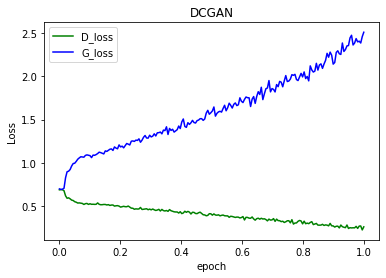

In [3]:
import matplotlib.pyplot as plt
x = np.linspace(0,1,200)
D_loss = D_loss[0:200]
G_loss = G_loss[0:200]
plt.figure()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("DCGAN")
plt.plot(x, D_loss,color='green', label = 'D_loss')
plt.plot(x, G_loss,color='blue', label = 'G_loss')
plt.legend()
plt.show()